In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, train_test_split
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

#### A sentiment analysis about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service"). https://data.world/crowdflower/airline-twitter-sentiment

In [2]:
df= pd.read_csv("/Users/ryanmartin/Downloads/twitter-airline-sentiment/Tweets.csv")

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
len(df)

14640

In [5]:
df.drop(['tweet_id', 'airline_sentiment_confidence', 'negativereason_confidence', 'negativereason', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_created', 'tweet_location', 'user_timezone'], axis=1, inplace=True)

In [6]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [7]:
df = df.rename(columns={"airline_sentiment": "class"})

In [8]:
df['text_length'] = df['text'].map(lambda text: len(text))

In [9]:
df = df.sort_values('class')

In [10]:
df.groupby('class').describe()

text_length                                                        
               count        mean        std   min   25%    50%    75%    max
class                                                                       
negative      9178.0  113.947919  30.719006  12.0  96.0  126.0  138.0  176.0
neutral       3099.0   87.359471  37.682903  12.0  57.0   87.0  123.0  167.0
positive      2363.0   86.082945  39.482103  12.0  52.0   86.0  124.0  186.0

#### Exploration

In [70]:
#Percentage of Positive/Negative
def rating(x):
    if x == "positive":
        return 0
    if x == "neutral":
        return 1
    if x == "negative":
        return 2
df_target = df['class'].apply(rating)
print("Positive: ", df_target.value_counts()[0]/len(df_target)*100,"%")
print("Negative: ", df_target.value_counts()[1]/len(df_target)*100,"%")
print("Neutral: ", df_target.value_counts()[2]/len(df_target)*100,"%")


Positive:  16.140710382513664 %
Negative:  21.168032786885245 %
Neutral:  62.69125683060109 %


In [12]:
df.head()

,class,text,text_length
7319,negative,@JetBlue how do we watch the oscars though rig...,92
11625,negative,@USAirways I've been sitting in the Charlotte ...,116
6512,negative,@SouthwestAir I do need help Cancelled Flighti...,97
11624,negative,"@USAirways No, they won't because after 5 hour...",134
6514,negative,@SouthwestAir your customer service is terribl...,90


#### We can visualize the stopwords of our tweets by using the wordcloud module

In [13]:
from wordcloud import WordCloud, STOPWORDS

In [14]:
cloud=df[df['class']=='negative']
words = ' '.join(cloud['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [15]:
cloud2=df[df['class']=='negative']
words = ' '.join(cloud['text'])
cleaned_word2 = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [16]:
wordcloud_neg = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

In [17]:
wordcloud_pos = WordCloud(stopwords=STOPWORDS,
                      background_color='gold',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word2)

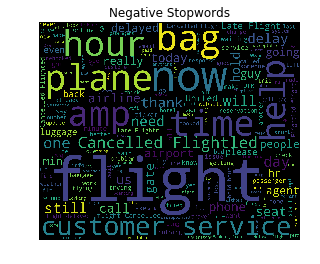

In [18]:

plt.title("Negative Stopwords")
plt.figure(1,figsize=(20, 20))
plt.imshow(wordcloud_neg)

plt.axis('off')
plt.show()

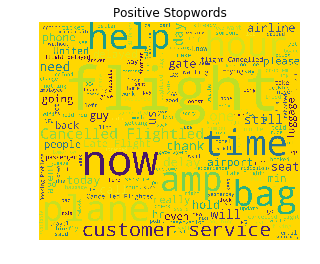

In [19]:
plt.title("Positive Stopwords")
plt.figure(1,figsize=(20, 20))
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.show()

#### The distribution of tweet lengths by class

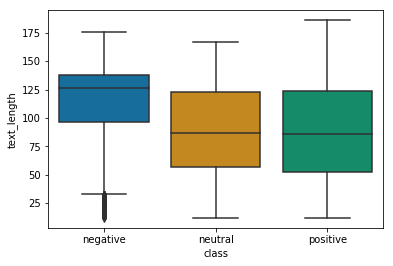

In [20]:
sns.boxplot(y="text_length", x ="class", data=df, palette = "colorblind");

#### Overall distribution of tweet lengths

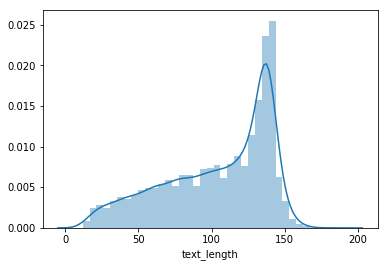

In [21]:
sns.distplot(df['text_length']);

In [22]:
df.text_length.describe()

count    14640.000000
mean       103.822063
std         36.277339
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text_length, dtype: float64

In [23]:
# Largest Tweet
df[df.text_length==186].values

array([['positive',
        "@USAirways Eyyyy! Cancelled Flightlations, Flight Booking Problemss, reFlight Booking Problemss, but y'all got me on the same flight out tonight (not tomorrow) &amp; the FC upgrade. Thx!",
        186]], dtype=object)

In [24]:
# Smallest Tweets
df[df.text_length==12].values

array([['negative', '@united Suck', 12],
       ['neutral', '@united done', 12],
       ['neutral', '@united past', 12],
       ['neutral', '@united done', 12],
       ['neutral', '@united sent', 12],
       ['neutral', '@united Pick', 12],
       ['positive', '@united thnx', 12],
       ['positive', '@united thnx', 12]], dtype=object)

### Preprocess The Data for Classification

#### Here we use NLTK corpus to remove stopwords which are basically usless data when creating our model

In [25]:
import re
import nltk
from nltk.corpus import stopwords

In [71]:
def tweet(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

In [72]:
def tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words))

In [73]:
df['sentiment']=df['class'].apply(lambda x: 0 if x=='negative' else 1)

In [74]:
from sklearn import preprocessing

In [75]:
df['clean_tweet']=df['text'].apply(lambda x: tweet(x))
df['text_length']=df['text'].apply(lambda x: tweet_length(x))

train,test = train_test_split(df,test_size=0.2,random_state=42)

In [76]:
df.head()

,class,text,text_length,sentiment,clean_tweet
7319,negative,@JetBlue how do we watch the oscars though rig...,8,0,jetblue watch oscars though right abc flight m...
11625,negative,@USAirways I've been sitting in the Charlotte ...,9,0,usairways sitting charlotte airport hours wait...
6512,negative,@SouthwestAir I do need help Cancelled Flighti...,10,0,southwestair need help cancelled flighting fli...
11624,negative,"@USAirways No, they won't because after 5 hour...",8,0,usairways hours holding give borrow phone long...
6514,negative,@SouthwestAir your customer service is terribl...,7,0,southwestair customer service terrible terribl...


In [77]:
train_clean_tweet=[]
for tweet in train['clean_tweet']:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in test['clean_tweet']:
    test_clean_tweet.append(tweet)

In [78]:
print(train_clean_tweet[:5])

['jetblue crew say safety say glad stay check information give costumers', 'americanair customer service line say experiencing high call volume spontaneously hangup person', 'americanair wish better mobile app look app united much seemless check', 'southwestair thank taking good care people als http co yywafkfi kevinswan alstdi life story', 'americanair lost wife luggage nobody gives answer say go call']


In [79]:
print(test_clean_tweet[:5])

['united personal device entertainment system great app crashing every mins glad free', 'southwestair geekstiel know last chance', 'americanair usairways help finding baggage reply asap direct details', 'united guys atrocious far better service silver delta platinum switching back delta', 'united worst airline beware maintain plain runway past hours']


### Feature Extraction

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

In [68]:
print(train_features)

  (0, 1671)	1
  (0, 2184)	1
  (0, 2266)	1
  (0, 4207)	1
  (0, 4217)	1
  (0, 5087)	1
  (0, 5379)	1
  (0, 8916)	1
  (0, 8995)	2
  (0, 9746)	1
  (1, 376)	1
  (1, 1420)	1
  (1, 2343)	1
  (1, 3464)	1
  (1, 4478)	1
  (1, 4625)	1
  (1, 5931)	1
  (1, 7619)	1
  (1, 8995)	1
  (1, 9170)	1
  (1, 9655)	1
  (1, 11182)	1
  (2, 376)	1
  (2, 503)	2
  (2, 991)	1
  :	:
  (11710, 3584)	1
  (11710, 4256)	1
  (11710, 5379)	1
  (11710, 5796)	1
  (11710, 7593)	1
  (11710, 7741)	1
  (11710, 8995)	1
  (11710, 9144)	1
  (11710, 9782)	1
  (11710, 10309)	1
  (11711, 822)	1
  (11711, 1704)	1
  (11711, 2343)	1
  (11711, 2623)	1
  (11711, 2987)	1
  (11711, 3361)	1
  (11711, 3523)	1
  (11711, 4428)	1
  (11711, 6438)	1
  (11711, 6868)	1
  (11711, 7619)	1
  (11711, 8860)	1
  (11711, 9263)	1
  (11711, 10693)	1
  (11711, 10848)	1


### SMOTE to deal with imbalanced data

In [81]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0, 
                           n_features=20, n_clusters_per_class=1, n_samples=10000, random_state=10)
print('Original dataset shape %s' % Counter(y))

sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_sample(train_features,train['sentiment'])
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 9000, 0: 1000})
Resampled dataset shape Counter({0: 7311, 1: 7311})


### Train Models

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

In [36]:
Classifiers = [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    GradientBoostingClassifier()]

In [37]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test['sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))  

Accuracy of LogisticRegressionis 0.637636612021858
Accuracy of KNeighborsClassifieris 0.5792349726775956


/Users/ryanmartin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy of SVCis 0.637636612021858
Accuracy of DecisionTreeClassifieris 0.7496584699453552
Accuracy of RandomForestClassifieris 0.8203551912568307


/Users/ryanmartin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy of ExtraTreesClassifieris 0.8080601092896175
Accuracy of AdaBoostClassifieris 0.7807377049180327
Accuracy of GaussianNBis 0.5867486338797814
Accuracy of GradientBoostingClassifieris 0.7824453551912568


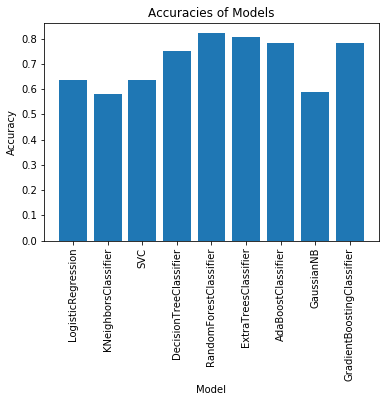

In [38]:
Index = [0,1,2,3,4,5,6,7,8]
plt.bar(Index,Accuracy)
plt.xticks(Index, Model,rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models');

#### I will now take the best model and train it using smote

In [46]:
clf=RandomForestClassifier(n_estimators = 200)
clf.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [47]:
actual = test['sentiment']
predictions=clf.predict(test_features)

In [48]:
confusion_matrix(actual,predictions)

array([[1525,  342],
       [ 243,  818]])

In [49]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

0.7938946037810335


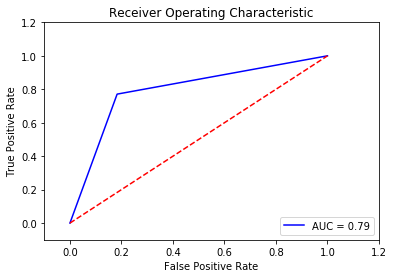

In [50]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

In [51]:
 accuracy = accuracy_score(predictions,test['sentiment'])

In [52]:
print(accuracy)

0.8002049180327869


#### Using SMOTE did not improve the accuracy of the model, so I will use the original pre-SMOTE model for my coreML converter

In [53]:
model = RandomForestClassifier(n_estimators = 200)
model.fit(train_features,train['sentiment'])
y_pred = model.predict(test_features)

In [54]:
import coremltools

In [55]:
coreml_model = coremltools.converters.sklearn.convert(model)

In [56]:
coreml_model.save('TwitterSentiment.mlmodel')